In [403]:
import pandas as pd 
import numpy as np 
import os
import kaleido
import plotly.express as px 
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,StratifiedKFold

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.utils import compute_class_weight
from sklearn import metrics
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from config.path_config import ROOT_DIR
import plotly.io as pio
import matplotlib.pyplot as plt
CONFIG_PATH = ""
TARGET = "SeriousDlqin2yrs"

from sklearn.preprocessing import KBinsDiscretizer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

TRAINING_PATH = os.path.join(ROOT_DIR,"data","processed","processed_training_5_exp_tuned.csv")
RAW_DATA_PATH = os.path.join(ROOT_DIR,"data","raw","cs-training.csv")
WRANGLED_DATA = os.path.join(ROOT_DIR,"data","interim","interim_training_forth_exp_tuned.csv")

In [404]:
data = pd.read_csv(RAW_DATA_PATH)

In [405]:
#outlier removal 
def outlier_treatment(data,col):
    q1,q3 = np.percentile(data[col] ,[25,75])
    iqr = q3-q1
    lower_range = q1 - (1.5 * iqr)
    upper_range = q3 + (1.5 * iqr)
    lower_range,upper_range
    data = data.drop(data[ (data[col] > upper_range) | (data[col] < lower_range) ].index )
    return data

data['MonthlyIncome'] = np.log1p(data['MonthlyIncome'])
data['DebtRatio'] = np.log1p(data['DebtRatio'])
data['RevolvingUtilizationOfUnsecuredLines'] = np.log1p(data['RevolvingUtilizationOfUnsecuredLines'])

In [352]:
data['MonthlyIncome']

0         9.118335
1         7.863651
2         8.020599
3         8.101981
5         8.160804
            ...   
149994    8.131825
149995    7.650169
149996    8.627840
149998    8.651199
149999    9.006877
Name: MonthlyIncome, Length: 112033, dtype: float64

In [406]:
data = outlier_treatment(data,col='MonthlyIncome')
data = outlier_treatment(data,col='RevolvingUtilizationOfUnsecuredLines')
data = outlier_treatment(data,col='DebtRatio')
data = outlier_treatment(data,col='age') 

In [407]:
data['MonthlyIncome'] = data['MonthlyIncome'].fillna(data['MonthlyIncome'].median())
data['NumberOfDependents'] = data['NumberOfDependents'].fillna(data['NumberOfDependents'].mode()[0])

In [134]:
#data = outlier_treatment(data,col='NumberOfOpenCreditLinesAndLoans')
#data = outlier_treatment(data,col='NumberOfTimes90DaysLate')
#data = outlier_treatment(data,col='NumberRealEstateLoansOrLines')
#data = outlier_treatment(data,col='NumberOfTime60-89DaysPastDueNotWorse') 
#data = outlier_treatment(data,col='NumberOfDependents') 
#data = outlier_treatment(data,col='age') 
#data = outlier_treatment(data,col='NumberOfTime30-59DaysPastDueNotWorse')  

In [143]:
hist_revolving_univariate = px.histogram(data_frame=data,x='RevolvingUtilizationOfUnsecuredLines',nbins=150,
             log_y=True,orientation='v',opacity=0.5,marginal='box',template='ggplot2',
             color=TARGET)
hist_revolving_univariate.update_layout(title='Logged count of RevolvingUtilizationOfUnsecuredLines')
pio.show(hist_revolving_univariate,validate=False,renderer='iframe')

In [145]:
hist_revolving_univariate = px.histogram(data_frame=data,x='age',nbins=50,
             log_y=True,orientation='v',opacity=0.5,marginal='box',template='ggplot2',
             color=TARGET)
hist_revolving_univariate.update_layout(title='Logged count of age')
pio.show(hist_revolving_univariate,validate=False,renderer='iframe')

In [146]:
hist_revolving_univariate = px.histogram(data_frame=data,x='MonthlyIncome',nbins=50,
             log_y=True,orientation='v',opacity=0.5,marginal='box',template='ggplot2',
             color=TARGET)
hist_revolving_univariate.update_layout(title='Logged count of MonthlyIncome')
pio.show(hist_revolving_univariate,validate=False,renderer='iframe')

In [336]:
data

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.568789,45,2,0.589442,9.118335,13,0,6,0,2.0
1,2,0,0.671490,40,0,0.115002,7.863651,4,0,0,0,1.0
2,3,0,0.505721,38,1,0.081684,8.020599,2,1,0,0,0.0
3,4,0,0.210107,30,0,0.035415,8.101981,5,0,0,0,0.0
5,6,0,0.193244,74,0,0.318895,8.160804,3,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149994,149995,0,0.326236,50,0,0.339534,8.131825,7,0,0,0,0.0
149995,149996,0,0.039868,74,0,0.203048,7.650169,4,0,1,0,0.0
149996,149997,0,0.262168,44,0,0.540324,8.627840,4,0,1,0,2.0
149998,149999,0,0.000000,30,0,0.000000,8.651199,4,0,0,0,0.0


In [148]:
hist_revolving_univariate = px.histogram(data_frame=data,x='DebtRatio',nbins=50,
             log_y=True,orientation='v',opacity=0.5,marginal='box',template='ggplot2',
             color=TARGET)
hist_revolving_univariate.update_layout(title='Logged count of DebtRatio')
pio.show(hist_revolving_univariate,validate=False,renderer='iframe')

In [149]:
hist_revolving_univariate = px.histogram(data_frame=data,x='NumberOfTime30-59DaysPastDueNotWorse',nbins=50,
             log_y=True,orientation='v',opacity=0.5,marginal='box',template='ggplot2',
             color=TARGET)
hist_revolving_univariate.update_layout(title='Logged count of NumberOfTime30-59DaysPastDueNotWorse')
pio.show(hist_revolving_univariate,validate=False,renderer='iframe')

In [136]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,109492.000000,109492.000000,109492.000000,109492.000000,109492.000000,109492.000000,109492.000000,109492.000000,109492.000000,109492.000000,109492.000000
mean,0.070398,0.333392,51.254786,0.470783,0.348603,5584.984602,8.442443,0.306662,0.957074,0.281199,0.804753
std,0.255817,0.354040,14.838604,4.624114,0.311785,2800.834674,5.065474,4.602025,1.016447,4.590002,1.121795
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.032645,40.000000,0.000000,0.132376,3419.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.176198,50.000000,0.000000,0.291602,5200.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.590165,62.000000,0.000000,0.473553,7500.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,1.376623,95.000000,98.000000,2.229441,12645.000000,57.000000,98.000000,25.000000,98.000000,20.000000


In [408]:
binned_data = data.copy()

In [409]:
import pandas as pd
import scipy.stats as stats
from scipy.stats import spearmanr
class CategoricalFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature

    @property
    def df_lite(self):
        df_lite = self.df
        df_lite['bin'] = df_lite[self.feature].fillna('MISSING')
        return df_lite[['bin', TARGET]]


class ContinuousFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature
        self.bin_min_size = int(len(self.df) * 0.05)

    def __generate_bins(self, bins_num):
        df = self.df[[self.feature, TARGET]]
        df['bin'] = pd.qcut(df[self.feature], bins_num, duplicates='drop') \
                    .apply(lambda x: x.left) \
                    .astype(float)
        return df

    def __generate_correct_bins(self, bins_max=20):
        for bins_num in range(bins_max, 1, -1):
            df = self.__generate_bins(bins_num)
            df_grouped = pd.DataFrame(df.groupby('bin') \
                                      .agg({self.feature: 'count',
                                            TARGET: 'sum'})) \
                                      .reset_index()
            r, p = spearmanr(df_grouped['bin'], df_grouped[TARGET])

            if (
                    abs(r)==1 and                                                        # check if woe for bins are monotonic
                    df_grouped[self.feature].min() > self.bin_min_size                   # check if bin size is greater than 5%
                    and not (df_grouped[self.feature] == df_grouped[TARGET]).any()      # check if number of good and bad is not equal to 0
            ):
                break

        return df

    @property
    def df_lite(self):
        df_lite = self.__generate_correct_bins()
        df_lite['bin'].fillna('MISSING', inplace=True)
        return df_lite[['bin', TARGET]]

In [410]:
pd.set_option('mode.chained_assignment', None)

class AttributeRelevance():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def bulk_iv(self, feats, iv, woe_extremes=False):
        iv_dict = {}
        for f in feats:
            iv_df, iv_value = iv.calculate_iv(f)
            if woe_extremes:
                iv_dict[f.feature] = [iv_value, iv_df['woe'].min(), iv_df['woe'].max()]
                cols = ['iv', 'woe_min', 'woe_max']
            else:
                iv_dict[f.feature] = iv_value
                cols = ['iv']
        df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=cols)
        return df

    def bulk_stats(self, feats, s):
        stats_dict = {}
        for f in feats:
            p_value, effect_size = s.calculate_chi(f)
            stats_dict[f.feature] = [p_value, effect_size]
        df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['p-value', 'effect_size'])
        return df

    def analyze(self, feats, iv, s=None, interpretation=False):
        df_iv = self.bulk_iv(feats, iv).sort_values(by='iv', ascending=False)
        if s is not None:
            df_stats = self.bulk_stats(feats, s)
            df_iv = df_iv.merge(df_stats, left_index=True, right_index=True)
        if interpretation:
            df_iv['iv_interpretation'] = df_iv['iv'].apply(iv.interpretation)
            if s is not None:
                df_iv['es_interpretation'] = df_iv['effect_size'].apply(s.interpretation)
        return df_iv

    def draw_iv(self, feats, iv):
        df = self.analyze(feats, iv)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='iv', data=df, palette=self.seq_palette(len(feats)))
        ax.set_title('IV values')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_extremes(self, feats, iv):
        df = self.bulk_iv(feats, iv, woe_extremes=True).sort_values(by='iv', ascending=False)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='woe_min', data=df, palette=self.seq_palette(len(feats)))
        sns.barplot(x=df.index, y='woe_max', data=df, palette=self.seq_palette(len(feats)))
        ax.axhline(y=0, color='black', linewidth=1)
        ax.set_title('Range of WOE values')
        ax.set_ylabel('WOE')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_multiplot(self, feats, iv):
        n = len(feats)
        nrows = int(np.ceil(n/3))
        fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*4))
        for i in range(n):
            iv_df, iv_value = iv.calculate_iv(feats[i])
            sns.barplot(x=feats[i].feature, y='woe', data=iv_df, color='#455872', ax=fig.axes[i])

        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=50)

        plt.tight_layout()
        plt.show()

class Analysis():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def group_by_feature(self, feat):
        df = feat.df_lite \
                            .groupby('bin') \
                            .agg({TARGET: ['count', 'sum']}) \
                            .reset_index()
        df.columns = [feat.feature, 'count', 'good']
        df['bad'] = df['count'] - df['good']
        return df

class StatsSignificance(Analysis):
    def calculate_chi(self, feat):
        df = self.group_by_feature(feat)
        df_chi = np.array(df[['good', 'bad']])
        n = df['count'].sum()

        chi = stats.chi2_contingency(df_chi)
        cramers_v = np.sqrt(chi[0] / n)          # assume that k=2 (good, bad)
        return chi[1], cramers_v

    @staticmethod
    def interpretation(cramers_v):
        if cramers_v < 0.1:
            return 'useless'
        elif cramers_v < 0.2:
            return 'weak'
        elif cramers_v < 0.4:
            return 'medium'
        elif cramers_v < 0.6:
            return 'strong'
        else:
            return 'very strong'

    def interpret_chi(self, feat):
        _, cramers_v = self.calculate_chi(feat)
        return self.interpretation(cramers_v)

    def print_chi(self, feat):
        p_value, cramers_v = self.calculate_chi(feat)
        print('P-value: %0.2f\nEffect size: %0.2f' % (p_value, cramers_v))
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(cramers_v)))


class IV(Analysis):
    @staticmethod
    def __perc_share(df, group_name):
        return df[group_name] / df[group_name].sum()

    def __calculate_perc_share(self, feat):
        df = self.group_by_feature(feat)
        df['perc_good'] = self.__perc_share(df, 'good')
        df['perc_bad'] = self.__perc_share(df, 'bad')
        df['perc_diff'] = df['perc_good'] - df['perc_bad']
        return df

    def __calculate_woe(self, feat):
        df = self.__calculate_perc_share(feat)
        df['woe'] = np.log(df['perc_good']/df['perc_bad'])
        df['woe'] = df['woe'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df

    def calculate_iv(self, feat):
        df = self.__calculate_woe(feat)
        df['iv'] = df['perc_diff'] * df['woe']
        return df, df['iv'].sum()

    def draw_woe(self, feat):
        iv_df, iv_value = self.calculate_iv(feat)
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=feat.feature, y='woe', data=iv_df, palette=self.seq_palette(len(iv_df.index)))
        ax.set_title('WOE visualization for: ' + feat.feature)
        plt.show()
        plt.show()

    @staticmethod
    def interpretation(iv):
        if iv < 0.02:
            return 'useless'
        elif iv < 0.1:
            return 'weak'
        elif iv < 0.3:
            return 'medium'
        elif iv < 0.5:
            return 'strong'
        else:
            return 'suspicious'

    def interpret_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        return self.interpretation(iv)

    def print_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        print('Information value: %0.2f' % iv)
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(iv)))

In [411]:
data.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [412]:
binned_data.drop('Unnamed: 0',axis=1,inplace=True)

In [413]:
feats_dict = {}
from pandas.api.types import is_numeric_dtype
for col in [c for c in binned_data.columns if c != TARGET]:
    if is_numeric_dtype(binned_data[col]):
        feats_dict[col] = ContinuousFeature(binned_data, col)
    else:
        feats_dict[col] = CategoricalFeature(binned_data, col)

feats = list(feats_dict.values())

In [414]:
feats_dict

{'RevolvingUtilizationOfUnsecuredLines': <__main__.ContinuousFeature at 0x7f5e13bd79d0>,
 'age': <__main__.ContinuousFeature at 0x7f5e133ada30>,
 'NumberOfTime30-59DaysPastDueNotWorse': <__main__.ContinuousFeature at 0x7f5e133ade20>,
 'DebtRatio': <__main__.ContinuousFeature at 0x7f5e5c16e6a0>,
 'MonthlyIncome': <__main__.ContinuousFeature at 0x7f5e188bf3a0>,
 'NumberOfOpenCreditLinesAndLoans': <__main__.ContinuousFeature at 0x7f5e188c8130>,
 'NumberOfTimes90DaysLate': <__main__.ContinuousFeature at 0x7f5e188c85b0>,
 'NumberRealEstateLoansOrLines': <__main__.ContinuousFeature at 0x7f5e13bdad60>,
 'NumberOfTime60-89DaysPastDueNotWorse': <__main__.ContinuousFeature at 0x7f5e13bda310>,
 'NumberOfDependents': <__main__.ContinuousFeature at 0x7f5e13db1f70>}

In [415]:
temp = []
for col in ['MonthlyIncome','RevolvingUtilizationOfUnsecuredLines','DebtRatio']:
    if is_numeric_dtype(binned_data[col]):
        features = feats_dict[col].df_lite
        features = features.rename(columns= {'bin':col})
        features.drop(TARGET,axis=1,inplace=True)
        temp.append(features)
    else:
        features = feats_dict[col].df_lite
        features = features.rename(columns= {'bin':col})
        features.drop(TARGET,axis=1,inplace=True)
        temp.append(features)
        
#feats = list(feats_dict.values())

In [416]:
binned_features = pd.concat(temp,axis=1)

In [ ]:
for col in 

In [417]:
binned_features

,MonthlyIncome,RevolvingUtilizationOfUnsecuredLines,DebtRatio
0,7800.000,0.5770,0.284
1,-0.001,0.5770,-0.001
2,2700.000,0.5770,-0.001
3,2700.000,0.1740,-0.001
4,10416.000,0.5770,-0.001
...,...,...,...
149994,2700.000,0.1740,0.284
149995,-0.001,0.0335,-0.001
149996,5000.000,0.1740,0.284
149998,5000.000,-0.0010,-0.001


In [392]:
binned_features.RevolvingUtilizationOfUnsecuredLines.unique()

array([ 0.577 ,  0.174 , -0.001 ,  0.0335])

In [393]:
binned_features[TARGET] = binned_data[TARGET].copy()

In [394]:
iv = IV()

In [395]:
for col in feats_dict.keys() : 
    iv_df, iv_value = iv.calculate_iv(feats_dict.get(col))
    iv_df
    print(f'{col} Information value: ', iv_value)

,RevolvingUtilizationOfUnsecuredLines,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,-0.0010,29505,578,28927,0.071526,0.263119,-0.191593,-1.302547,0.249559
1,0.0335,29505,695,28810,0.086004,0.262054,-0.176050,-1.114156,0.196147
2,0.1740,29505,1586,27919,0.196263,0.253950,-0.057687,-0.257682,0.014865
3,0.5770,29505,5222,24283,0.646207,0.220877,0.425330,1.073514,0.456598


RevolvingUtilizationOfUnsecuredLines Information value:  0.9171687913087754


,age,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,20.999,17978,1933,16045,0.239203,0.145945,0.093258,0.494086,0.046078
1,35.000,16459,1504,14955,0.186116,0.136030,0.050086,0.313493,0.015701
2,42.000,17426,1384,16042,0.171266,0.145917,0.025349,0.160178,0.004060
3,48.000,17773,1338,16435,0.165574,0.149492,0.016082,0.102173,0.001643
4,54.000,15798,887,14911,0.109764,0.135630,-0.025866,-0.211599,0.005473
5,60.000,15862,628,15234,0.077713,0.138568,-0.060855,-0.578335,0.035194
6,67.000,16724,407,16317,0.050365,0.148419,-0.098054,-1.080740,0.105970


age Information value:  0.21412057572492382


,NumberOfTime30-59DaysPastDueNotWorse,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,-0.001,118020,8081,109939,1.0,1.0,0.0,0.0,0.0


NumberOfTime30-59DaysPastDueNotWorse Information value:  0.0


,DebtRatio,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,-0.001,59010,3412,55598,0.422225,0.505717,-0.083492,-0.180439,0.015065
1,0.284,59010,4669,54341,0.577775,0.494283,0.083492,0.156076,0.013031


DebtRatio Information value:  0.028096213692980647


,MonthlyIncome,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,-0.001,17039,1589,15450,0.196634,0.140532,0.056102,0.335906,0.018845
1,2700.000,16687,1495,15192,0.185002,0.138186,0.046816,0.291767,0.013659
2,3894.000,18510,1411,17099,0.174607,0.155532,0.019075,0.115689,0.002207
3,5000.000,15208,1026,14182,0.126964,0.128999,-0.002034,-0.015896,0.000032
4,6050.000,17045,997,16048,0.123376,0.145972,-0.022596,-0.168179,0.003800
5,7800.000,16792,848,15944,0.104938,0.145026,-0.040088,-0.323547,0.012970
6,10416.000,16739,715,16024,0.088479,0.145754,-0.057274,-0.499150,0.028589


MonthlyIncome Information value:  0.08010261068675203


,NumberOfOpenCreditLinesAndLoans,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,-0.001,65315,4693,60622,0.580745,0.551415,0.02933,0.051824,0.001520
1,8.000,52705,3388,49317,0.419255,0.448585,-0.02933,-0.067619,0.001983


NumberOfOpenCreditLinesAndLoans Information value:  0.003503280165702477


,NumberOfTimes90DaysLate,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,-0.001,118020,8081,109939,1.0,1.0,0.0,0.0,0.0


NumberOfTimes90DaysLate Information value:  0.0


,NumberRealEstateLoansOrLines,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,-0.001,84175,5924,78251,0.733078,0.711767,0.021310,0.029500,0.000629
1,1.000,25732,1473,24259,0.182279,0.220659,-0.038379,-0.191077,0.007333
2,2.000,8113,684,7429,0.084643,0.067574,0.017069,0.225221,0.003844


NumberRealEstateLoansOrLines Information value:  0.011806379521591968


,NumberOfTime60-89DaysPastDueNotWorse,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,-0.001,118020,8081,109939,1.0,1.0,0.0,0.0,0.0


NumberOfTime60-89DaysPastDueNotWorse Information value:  0.0


,NumberOfDependents,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,-0.001,88670,5549,83121,0.686672,0.756065,-0.069392,-0.096270,0.006680
1,1.000,17462,1418,16044,0.175473,0.145935,0.029538,0.184323,0.005444
2,2.000,11888,1114,10774,0.137854,0.098000,0.039854,0.341231,0.013600


NumberOfDependents Information value:  0.02572444052518881


In [349]:
for col in feats_dict.keys() : 
    print(f'{col} IV Val : ')
    iv.print_iv(feats_dict.get(col))
    print('%s is a %s predictor.' % (feats_dict.get(col).feature.capitalize(), iv.interpret_iv(feats_dict.get(col))))
    print()
    

RevolvingUtilizationOfUnsecuredLines IV Val : 
Information value: 0.94
Revolvingutilizationofunsecuredlines is a suspicious predictor
Revolvingutilizationofunsecuredlines is a suspicious predictor.

age IV Val : 
Information value: 0.21
Age is a medium predictor
Age is a medium predictor.

NumberOfTime30-59DaysPastDueNotWorse IV Val : 
Information value: 0.00
Numberoftime30-59dayspastduenotworse is a useless predictor
Numberoftime30-59dayspastduenotworse is a useless predictor.

DebtRatio IV Val : 
Information value: 0.03
Debtratio is a weak predictor
Debtratio is a weak predictor.

MonthlyIncome IV Val : 
Information value: 0.08
Monthlyincome is a weak predictor
Monthlyincome is a weak predictor.

NumberOfOpenCreditLinesAndLoans IV Val : 
Information value: 0.00
Numberofopencreditlinesandloans is a useless predictor
Numberofopencreditlinesandloans is a useless predictor.

NumberOfTimes90DaysLate IV Val : 
Information value: 0.00
Numberoftimes90dayslate is a useless predictor
Numberoft

In [350]:
feats = list(feats_dict.values())

In [351]:
ar = AttributeRelevance()
ar.bulk_iv(feats, iv).head()

,iv
RevolvingUtilizationOfUnsecuredLines,0.937949
age,0.213403
NumberOfTime30-59DaysPastDueNotWorse,0.000000
DebtRatio,0.028138
MonthlyIncome,0.084722


In [287]:
ar.bulk_iv(feats, iv, woe_extremes=True).head()

,iv,woe_min,woe_max
Unnamed: 0,0.000012,-0.003425,0.003415
RevolvingUtilizationOfUnsecuredLines,1.016361,-1.340558,1.111413
age,0.256998,-1.132145,0.563249
NumberOfTime30-59DaysPastDueNotWorse,0.000000,0.000000,0.000000
DebtRatio,0.012360,-0.108543,0.146810


In [288]:
s = StatsSignificance()

In [289]:
ar.analyze(feats, iv).head()

,iv
RevolvingUtilizationOfUnsecuredLines,1.016361
age,0.256998
MonthlyIncome,0.073622
NumberOfDependents,0.027233
DebtRatio,0.012360


In [292]:
ar.analyze(feats, iv, s, interpretation=True).head()

,iv,p-value,effect_size,iv_interpretation,es_interpretation
RevolvingUtilizationOfUnsecuredLines,1.016361,0.000000e+00,0.263693,suspicious,medium
age,0.256998,0.000000e+00,0.117031,medium,weak
MonthlyIncome,0.073622,3.853619e-145,0.067916,weak,useless
NumberOfDependents,0.027233,5.266442e-59,0.042704,weak,useless
DebtRatio,0.012360,1.812188e-26,0.028112,useless,useless


In [236]:
import seaborn as sns

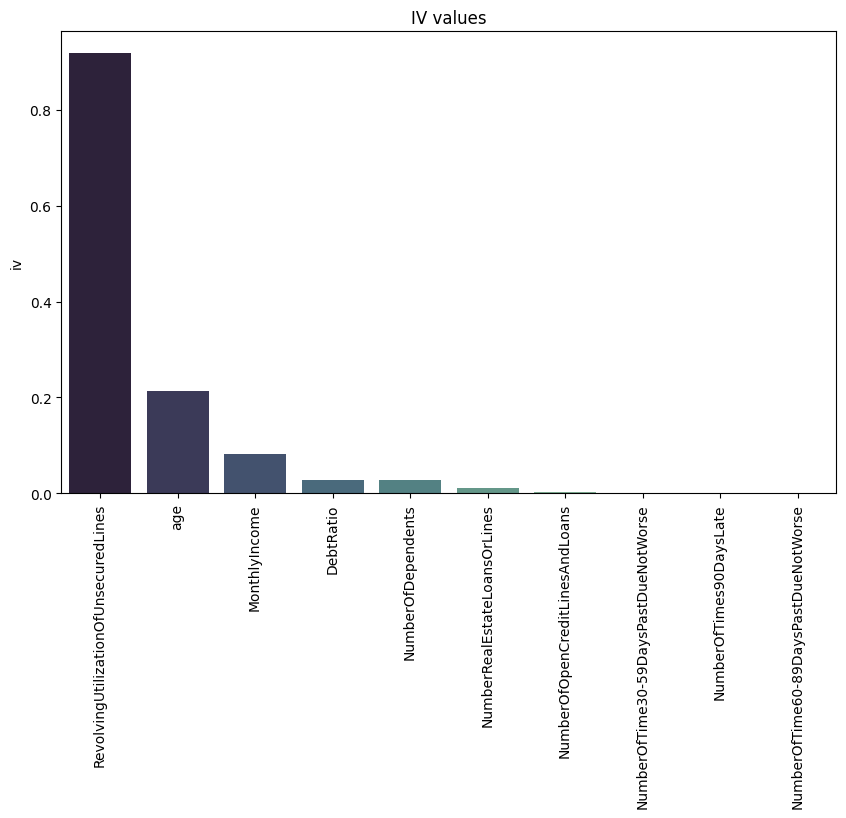

In [237]:
ar.draw_iv(feats, iv)

In [257]:
binned_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

binned_features = binned_features[[TARGET,
                                   'RevolvingUtilizationOfUnsecuredLines','age',
                                   'MonthlyIncome','NumberOfDependents','DebtRatio']]

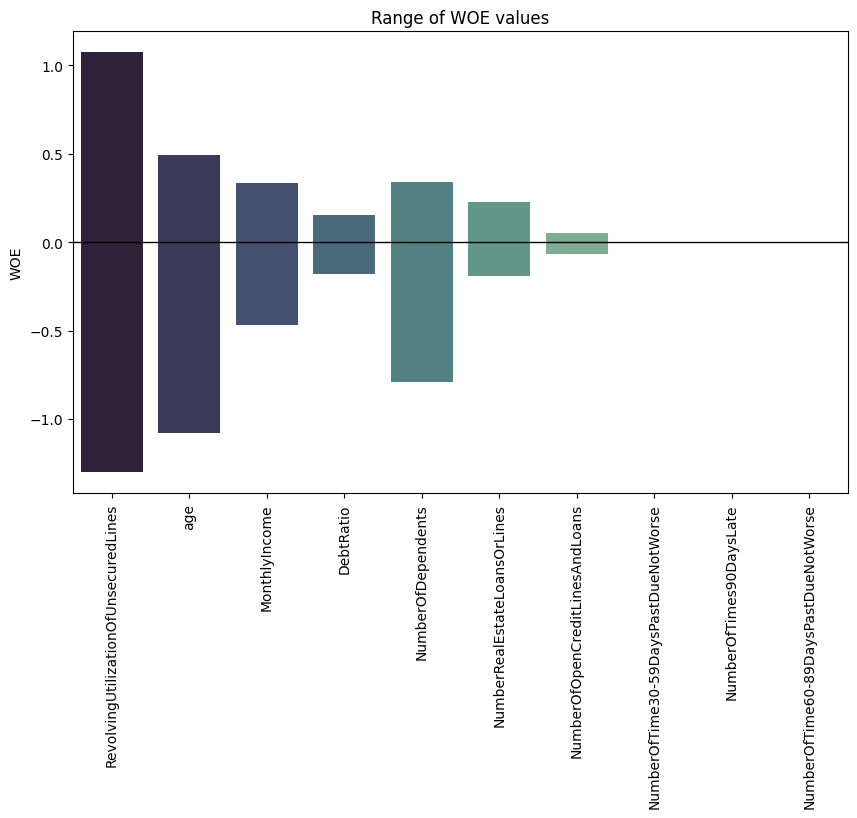

In [238]:
ar.draw_woe_extremes(feats, iv)

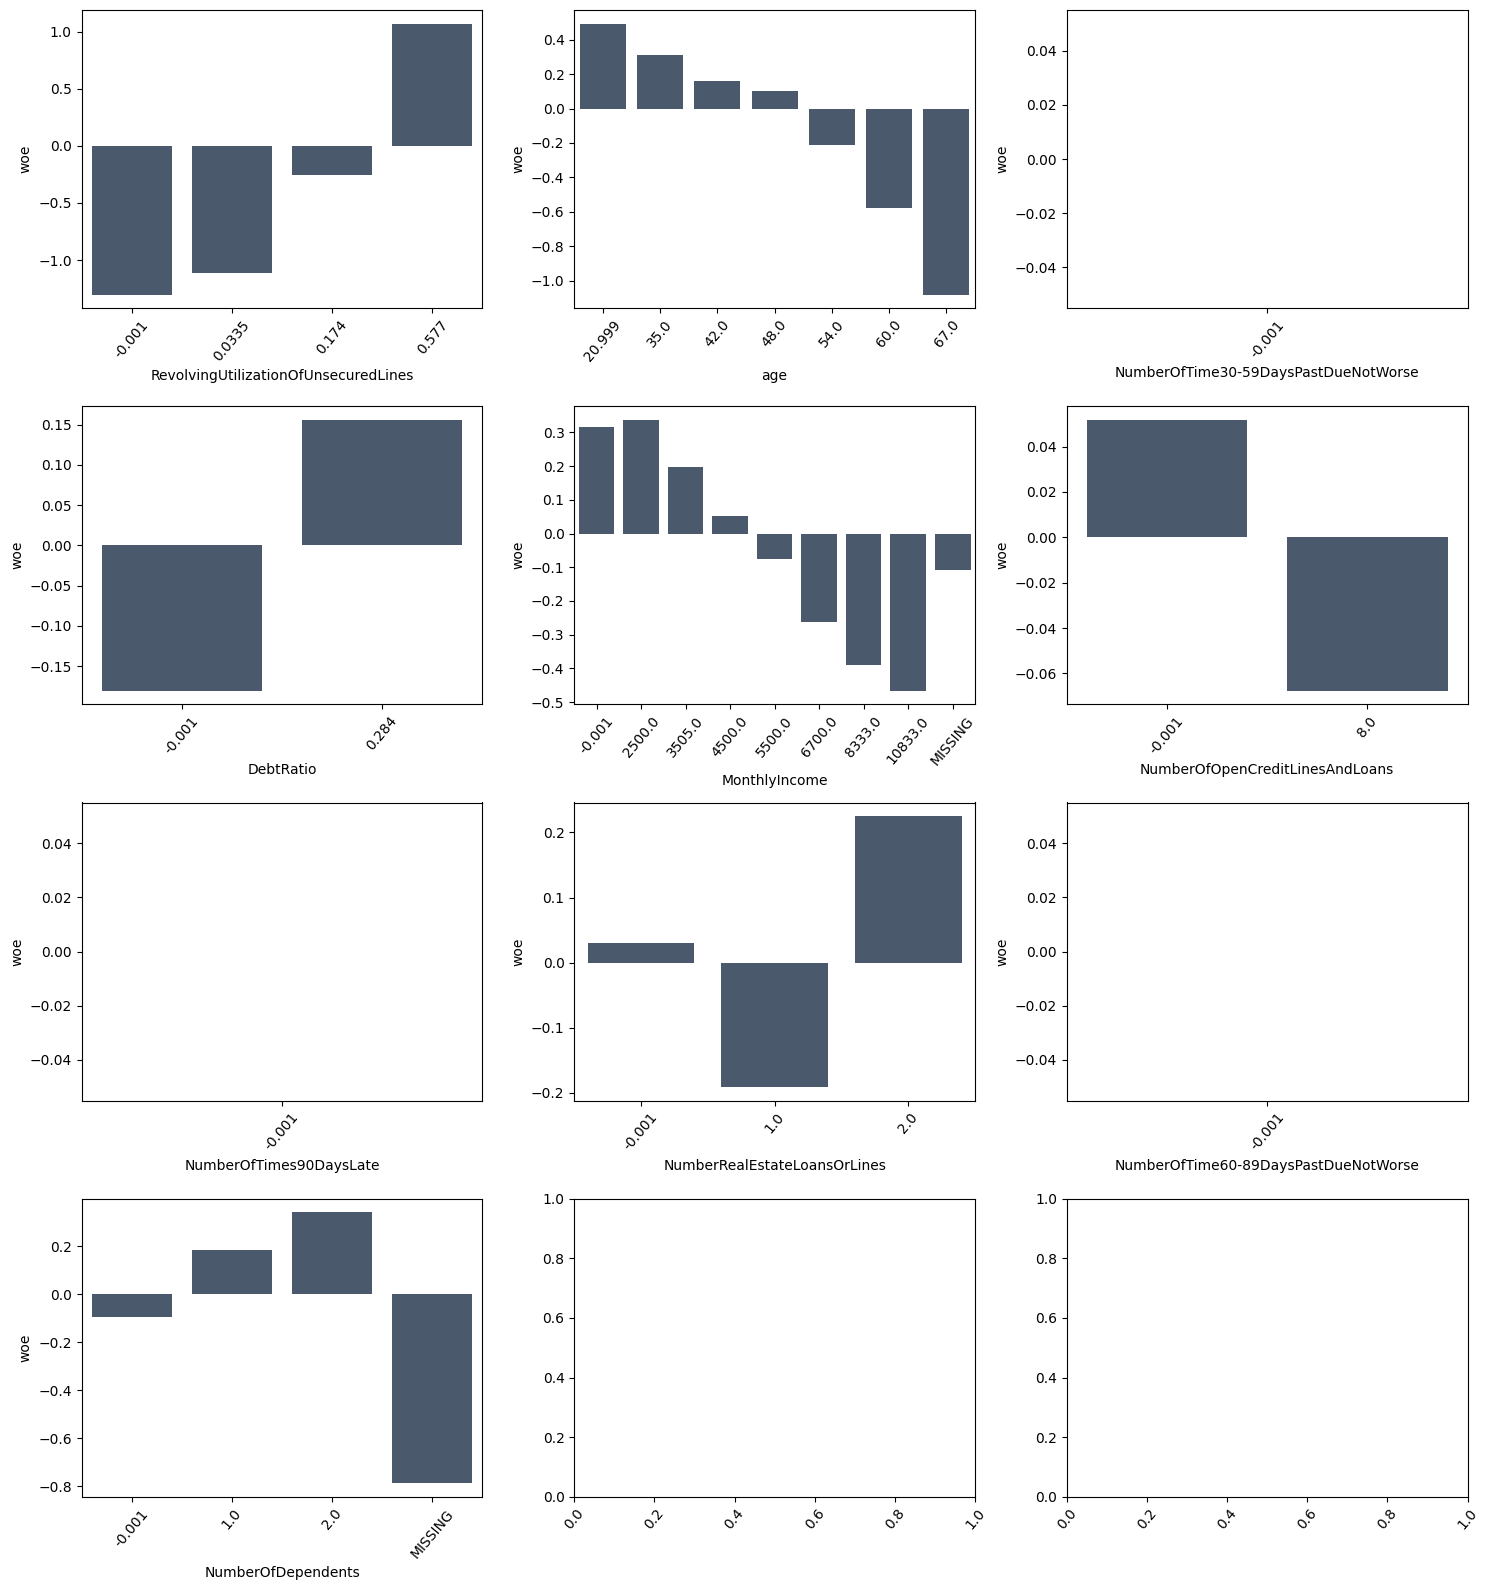

In [240]:
fo

In [396]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn import metrics
fold = StratifiedKFold(5)
def begin_cross_validation(X,Y,model,fold=fold) : 
    scoring_dict = {'auc':[]}
    for train_idx,test_idx in fold.split(X,Y) : 
        train_x,val_x = X.iloc[train_idx],X.iloc[test_idx]
        train_y,val_y = Y.iloc[train_idx],Y.iloc[test_idx]
        #train model 

        model.fit(train_x,train_y)
        y_pred = model.predict_proba(val_x)
        #calculate metrics 
        scoring_dict["auc"].append(metrics.roc_auc_score(val_y, y_pred[:, 1]))


    #print the scoring 
    print(f'''Scoring: AUC :{np.mean(scoring_dict['auc'])}
     ''')
    return np.mean(scoring_dict['auc'])

In [397]:
binned_features.columns

Index(['MonthlyIncome', 'RevolvingUtilizationOfUnsecuredLines', 'DebtRatio',
       'SeriousDlqin2yrs'],
      dtype='object')

In [398]:
binned_features.NumberOfDependents = binned_features.NumberOfDependents.dropna()

AttributeError: 'DataFrame' object has no attribute 'NumberOfDependents'

In [399]:
binned_features.MonthlyIncome = binned_features.MonthlyIncome.dropna()

In [388]:
X = binned_features.drop(TARGET,axis=1)
Y = binned_features[TARGET]


In [389]:
clf_model = LogisticRegression(class_weight='balanced')
begin_cross_validation(X,Y,clf_model,)

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Scoring: AUC :0.7626902509223052
     


0.7626902509223052

## Hide

In [140]:
#binning dataset 
import joblib
from sklearn.preprocessing import KBinsDiscretizer
binner = KBinsDiscretizer(encode='ordinal',strategy='kmeans')
for col in binned_data.drop(TARGET,axis=1).columns : 
    binner.fit(binned_data[col].to_numpy().reshape(-1,1))
    joblib.dump(binner,f'binner_{col}.joblib')
    binned_data[col] = binner.transform(binned_data[col].to_numpy().reshape(-1,1))

In [142]:
binned_data.NumberRealEstateLoansOrLines.unique()

array([2., 0., 1., 3., 4.])

In [108]:
bin_columns = [x for x in data.columns if x.startswith('bin')]

In [110]:
bin_columns = ['binned_RevolvingUtilizationOfUnsecuredLines',
 'binned_age',
 'binned_NumberOfTime30-59DaysPastDueNotWorse',
 'binned_DebtRatio',
 'binned_MonthlyIncome',
 'binned_NumberOfOpenCreditLinesAndLoans',
 'binned_NumberOfTimes90DaysLate',
 'binned_NumberRealEstateLoansOrLines',
 'binned_NumberOfTime60-89DaysPastDueNotWorse',
 'binned_NumberOfDependents',TARGET]

In [112]:
binned_data = data[bin_columns]

In [113]:
binned_data

,binned_RevolvingUtilizationOfUnsecuredLines,binned_age,binned_NumberOfTime30-59DaysPastDueNotWorse,binned_DebtRatio,binned_MonthlyIncome,binned_NumberOfOpenCreditLinesAndLoans,binned_NumberOfTimes90DaysLate,binned_NumberRealEstateLoansOrLines,binned_NumberOfTime60-89DaysPastDueNotWorse,binned_NumberOfDependents,SeriousDlqin2yrs
0,4.0,1.0,0.0,4.0,4.0,4.0,0.0,2.0,0.0,2.0,1
1,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0
5,2.0,4.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
149994,3.0,2.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0
149995,1.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
149996,2.0,1.0,0.0,4.0,2.0,1.0,0.0,1.0,0.0,2.0,0
149998,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0


In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn import metrics
fold = StratifiedKFold(5)
def begin_cross_validation(X,Y,model,fold=fold) : 
    scoring_dict = {'auc':[]}
    for train_idx,test_idx in fold.split(X,Y) : 
        train_x,val_x = X.iloc[train_idx],X.iloc[test_idx]
        train_y,val_y = Y.iloc[train_idx],Y.iloc[test_idx]
        #train model 

        model.fit(train_x,train_y)
        y_pred = model.predict_proba(val_x)
        #calculate metrics 
        scoring_dict["auc"].append(metrics.roc_auc_score(val_y, y_pred[:, 1]))


    #print the scoring 
    print(f'''Scoring: AUC :{np.mean(scoring_dict['auc'])}
     ''')
    return np.mean(scoring_dict['auc'])

In [117]:
X = binned_data.drop(TARGET,axis=1)
Y = binned_data[TARGET]


In [118]:
clf_model = LogisticRegression()
begin_cross_validation(X,Y,clf_model)

Scoring: AUC :0.7728151383189903
     


0.7728151383189903